TokaMaker Example: Dipole equilibrium and stability {#doc_tMaker_dipole_ex2}
==========
In this example we demonstrate:

 1. How to create a simple dipole equilibrium
 2. How to compute linear growth rates for the dipole

This example utilizes the mesh built in \ref doc_tMaker_dipole_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_spline_flux_fun

## Setup calculation

### Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myenv = OFT_env(nthreads=1)
mygs = TokaMaker(myenv)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_dipole
Revision id:          aab6a5a
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    1
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_7667/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_dipole_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4).

**Note:** We also need to set `settings.dipole_mode=True` to set dipole specific options for TokaMaker.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('dipole_mesh.h5')
mygs.settings.dipole_mode=True
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2)


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.000E+00
    # of points  =    4582
    # of edges   =   13557
    # of cells   =    8976
    # of boundary points =     186
    # of boundary edges  =     186
    # of boundary cells  =     186
  Resolution statistics:
    hmin =  1.252E-02
    hrms =  4.156E-02
    hmax =  9.351E-02
  Surface grounded at vertex      61


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    4.0010000000000002E-003


## Compute force on dipole from levitation/shaping coil
As the name suggests, a levitated dipole is supported by the magnetic interaction of the dipole coil and an external levitation coil, which is located above the dipole in this example. Therefore with a single levitation coil the current in this coil needs to be consistent with the required force to support the dipole.

### Compute levitation coil vacuum field
First, we compute the vacuum field associated with the levitation coil for unit current.

   1  8.1808E-08


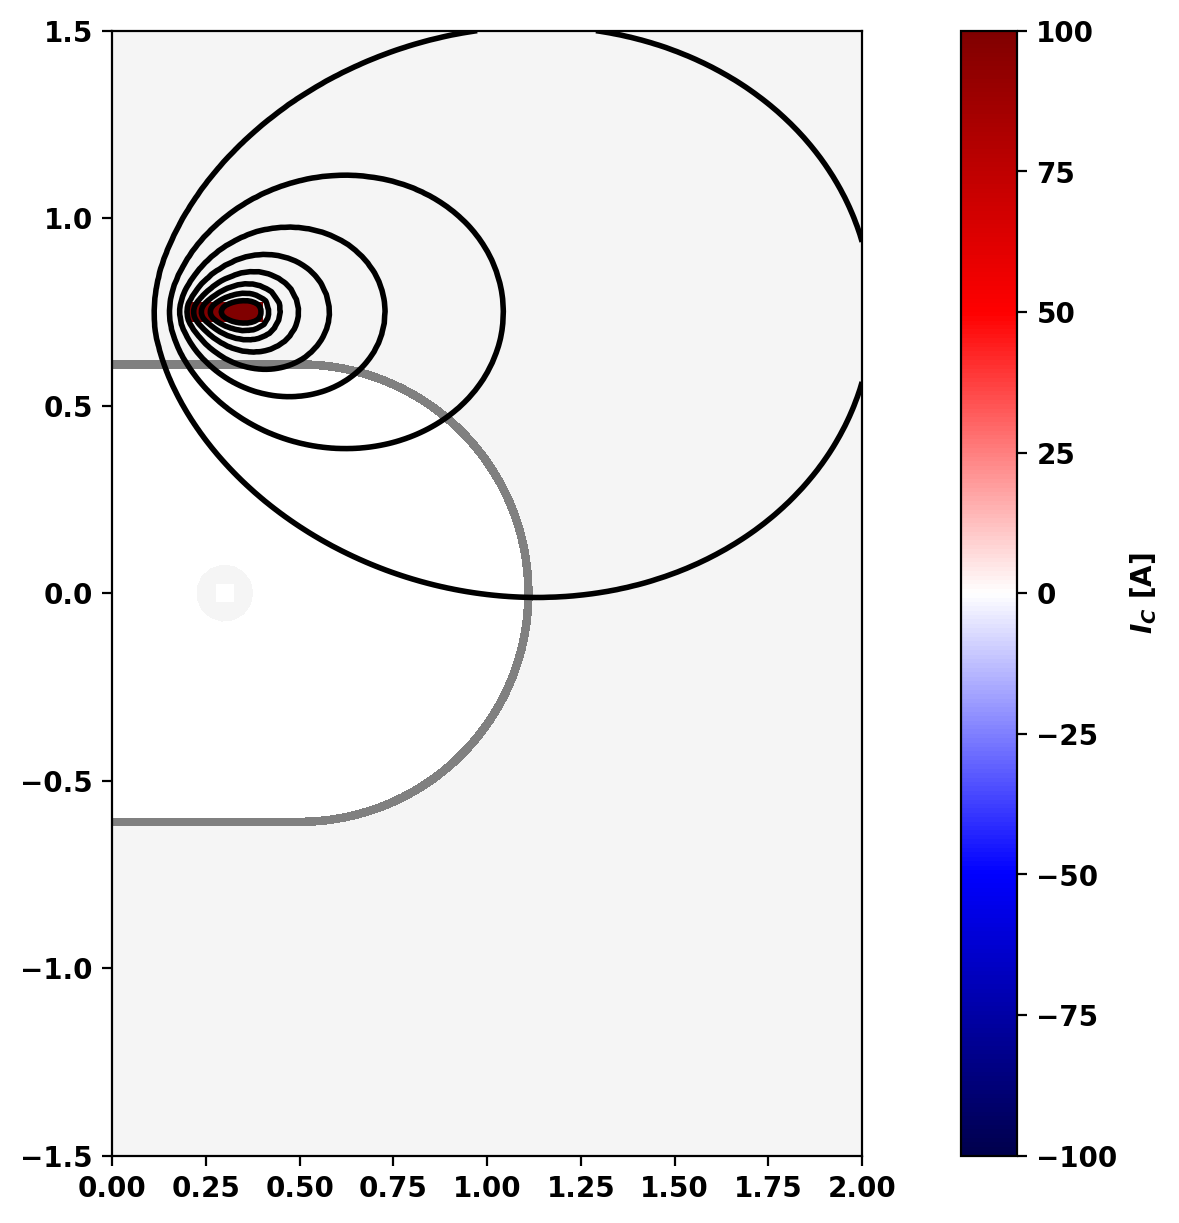

In [5]:
coil_currents = {'DIPOLE': 0.0, 'LEV': 1.0}
mygs.set_coil_currents(coil_currents)
psi_lev = mygs.vac_solve()
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_lev,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None,opoint_color=None)

### Compute B-field and forces
Now we compute the magnetic field from the levitation coil within the dipole using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_field_eval "get_field_eval()" and then integrate to compute the force using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.area_integral "area_integral()". Note that the current density in normal coils is uniform so the poloidal integrand is simply $- 2 \pi r \frac{N_{turns}}{A_C} B_r $, $N_{turns}$ and $A_C$ are the number of turns and area of the coil.

Later on this will be used to set the coil current.

Force due to levitation coil [N/A^2]:  0.000809096556909462


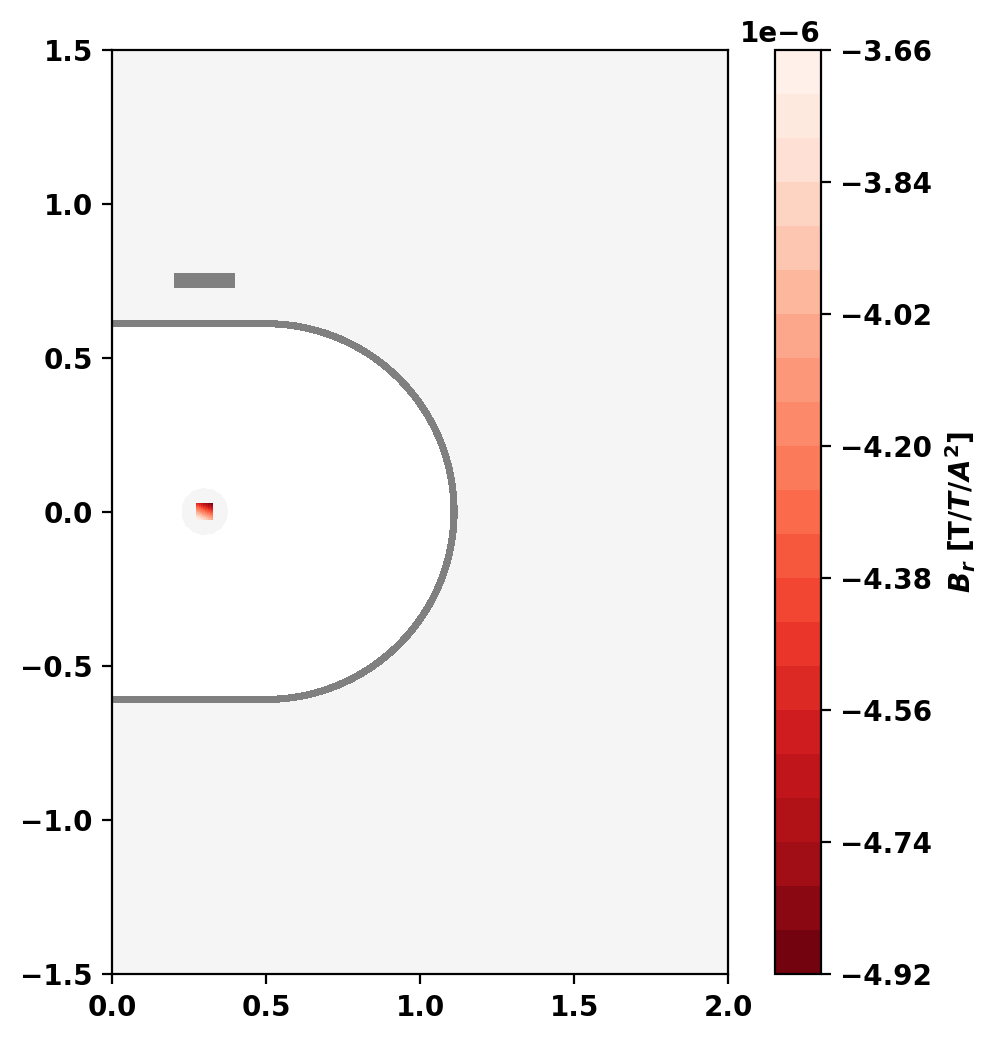

In [6]:
# Compute masks and get turn count for DIPOLE coil
pt_mask = np.zeros((mygs.r.shape[0],), dtype=np.int32)
dipole_reg = mygs.coil_sets['DIPOLE']['sub_coils'][0]['reg_id']
dipole_nturns = mygs.coil_sets['DIPOLE']['sub_coils'][0]['nturns']
pt_mask[mygs.lc[mygs.reg==dipole_reg,:]] = 1

# Evaluate Br-field for levitation coil
mygs.set_psi(psi_lev)
field_eval = mygs.get_field_eval('B')
Br_dipole = np.zeros((mygs.r.shape[0],))
for i in range(mygs.r.shape[0]):
    if pt_mask[i] == 0:
        continue
    Btmp = field_eval.eval(mygs.r[i,:2])
    Br_dipole[i] = Btmp[0]
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[mygs.reg==dipole_reg,:],Br_dipole,levels=20,cmap='Reds_r')
fig.colorbar(clf,ax=ax,label=r'$B_r$ [T/$T/A^2$]')

# Compute total force per Amp in DIPOLE and other coil
dipole_area = mygs.area_integral(np.ones_like(Br_dipole),reg_mask=dipole_reg)
unit_coil_force = -2.0*np.pi*mygs.area_integral(mygs.r[:,0]*Br_dipole,reg_mask=dipole_reg)*dipole_nturns/dipole_area
print('Force due to levitation coil [N/A^2]: ',unit_coil_force)

## Compute stability of dipole in vacuum field
As the coil is not rigidly supported it can also be susceptible to a vertical instability itself. To compute this we need to look at the variation of the levitation force under displacement in z. This can be done using a similar process as the force, but replacing the magnetic field with its gradient $\frac{\partial B_r}{\partial z}$.

Here the value is positive, which indicates an unstable system!

Positive means this is unstable (it should be)!  0.0031681433086389456


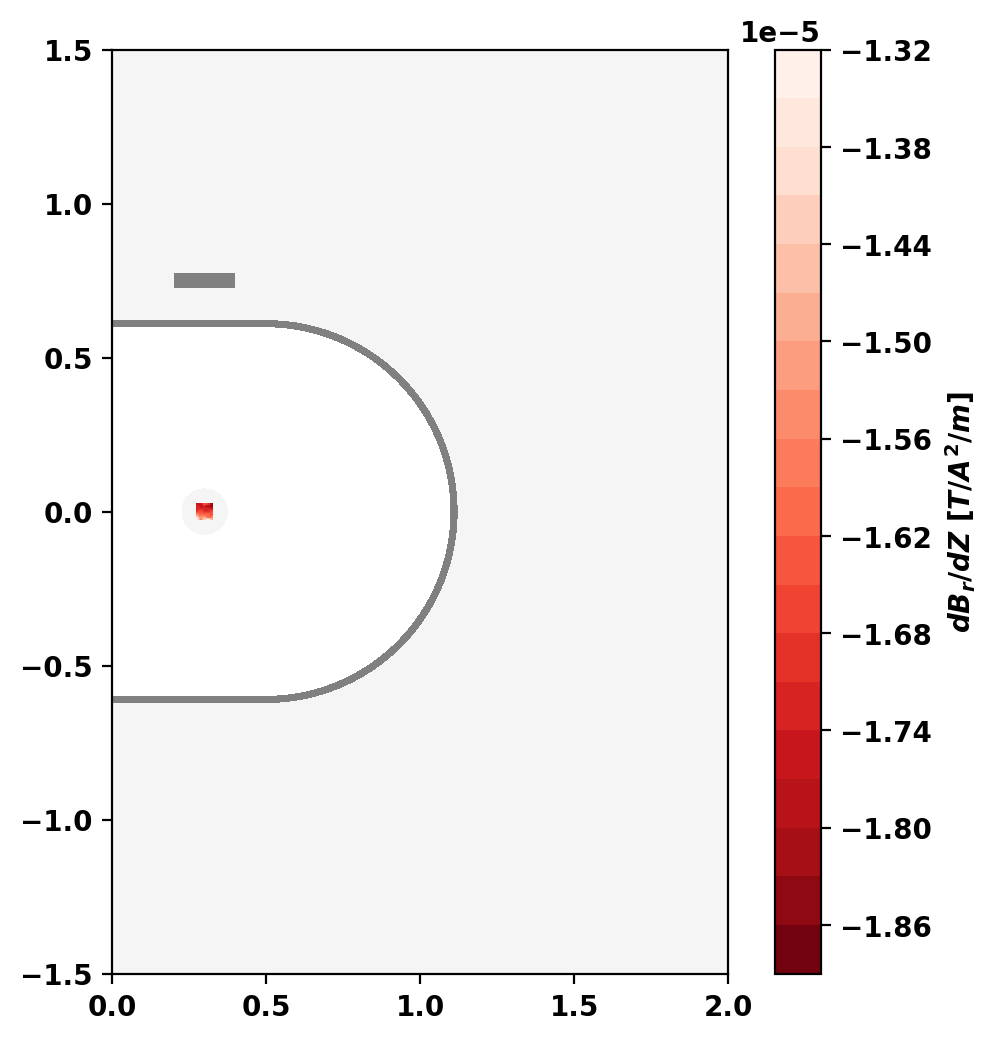

In [7]:
# Evaluate dBr/dz
field_eval = mygs.get_field_eval('dBr')
dBrdZ_dipole = np.zeros((mygs.r.shape[0],))
for i in range(mygs.r.shape[0]):
    if pt_mask[i] == 0:
        continue
    Btmp = field_eval.eval(mygs.r[i,:2])
    dBrdZ_dipole[i] = Btmp[1]
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[mygs.reg==dipole_reg,:],dBrdZ_dipole,levels=20,cmap='Reds_r')
fig.colorbar(clf,ax=ax,label=r'$dB_r/dZ$ [$T/A^2/m$]')
#
unit_coil_force_dz = -2.0*np.pi*mygs.area_integral(mygs.r[:,0]*dBrdZ_dipole,reg_mask=dipole_reg)*dipole_nturns/dipole_area
print('Positive means this is unstable (it should be)! ',unit_coil_force_dz)

## Compute an equilibrium

   1  2.7723E+01
Dipole force = 5493.6


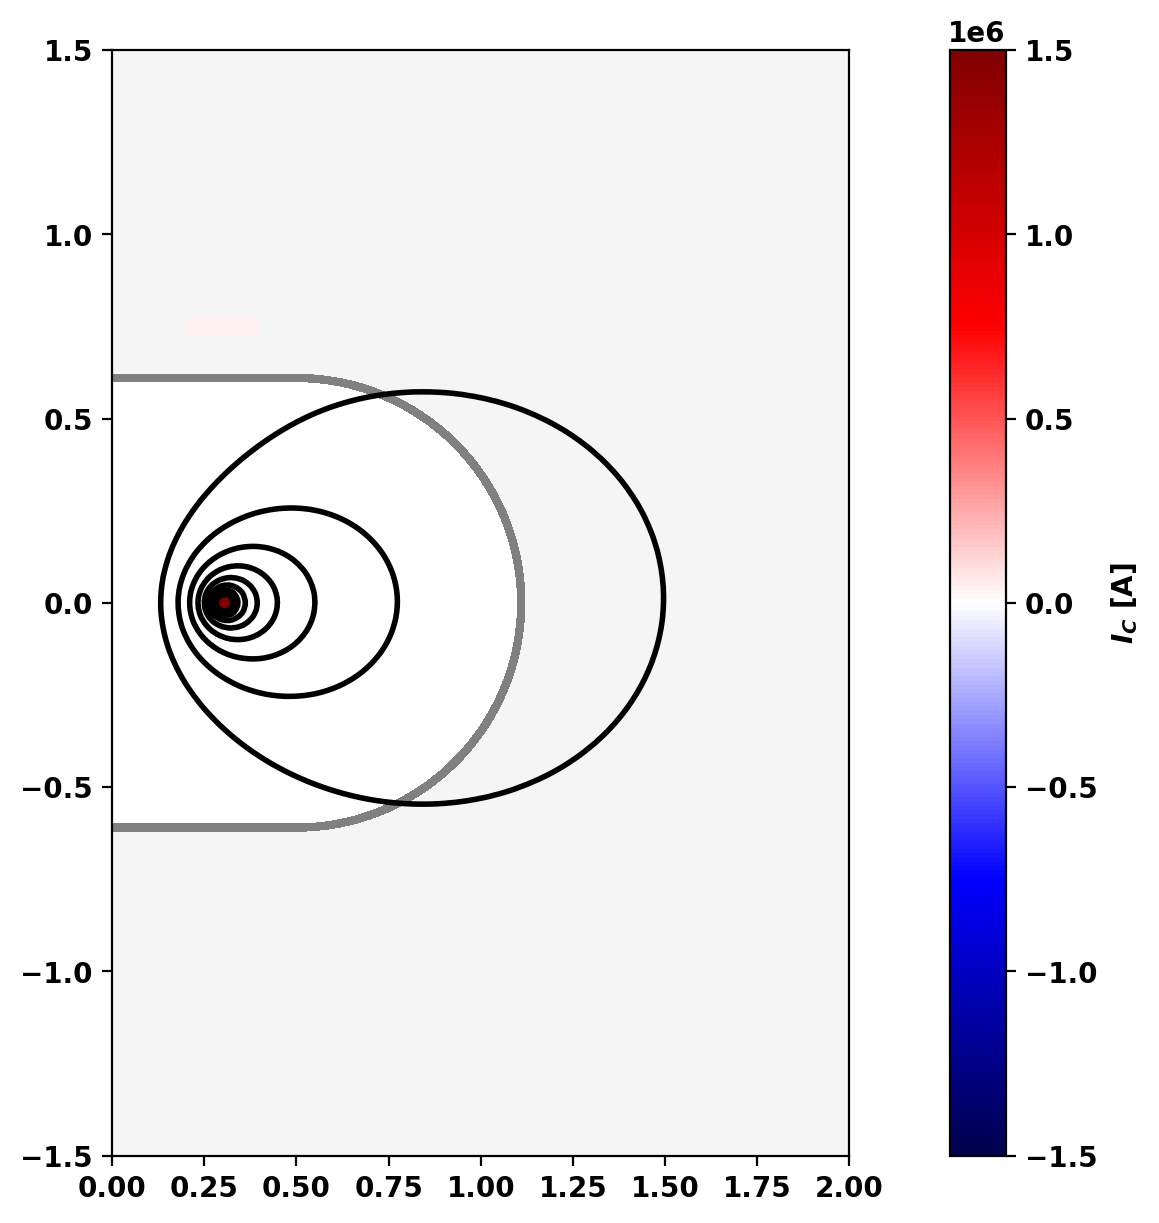

In [8]:
dipole_mass = 560.0
coil_currents = {'DIPOLE': 1.5E4}
coil_currents['LEV'] = (dipole_mass*9.81)/(unit_coil_force*coil_currents['DIPOLE'])
mygs.set_coil_currents(coil_currents)
mygs.set_psi(0.0*psi_lev)
psi_vac = mygs.vac_solve()
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_vac,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None,opoint_color=None)
#
print('Dipole force = {0}'.format(unit_coil_force*coil_currents['DIPOLE']*coil_currents['LEV']))

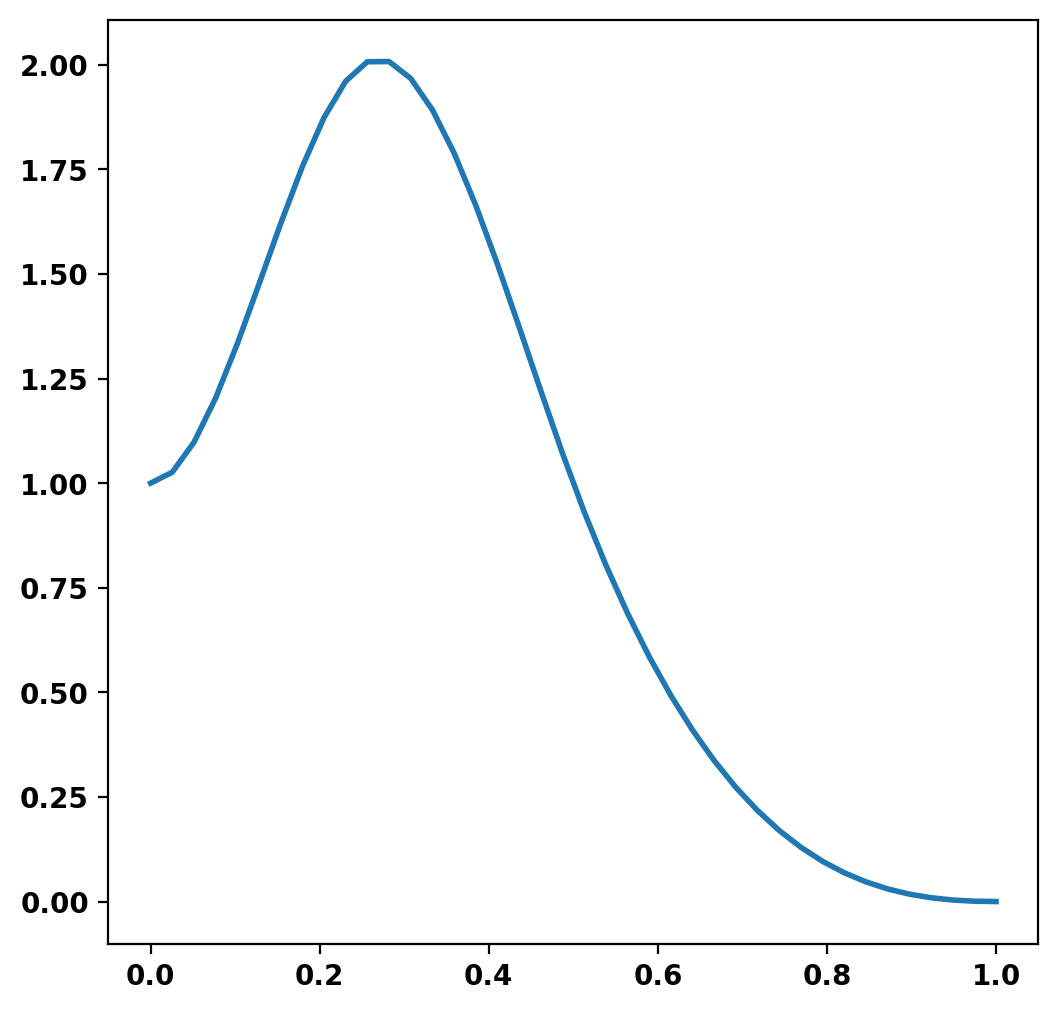

In [9]:
prof = create_spline_flux_fun(40,[0.0,0.25,0.5,1.0],[0.5,1.0,0.5,0.0],axis_bc=[1,0.0],edge_bc=[1,0.0])
plt.plot(prof['x'],prof['y'])
mygs.set_profiles(pp_prof=prof)

In [10]:
# Initialize with some tiny current (vacuum flux is all we really want)
mygs.set_targets(Ip=1.E-1)
err_flag = mygs.init_psi()
psi_init = mygs.get_psi()

# Solve with real current
mygs.set_targets(Ip=2.E5, Ip_ratio=1.E-2) # This Ip ratio means almost all the current is due to pressure
err_flag = mygs.solve()

Starting non-linear GS solver
     1  6.4969E-03  5.4202E+00  3.9425E-03  3.7174E-01  1.5246E-02  0.0000E+00
     2  6.5956E-03  4.5071E+00  1.1628E-03  3.7174E-01  1.5246E-02  0.0000E+00
     3  6.6650E-03  4.2502E+00  4.3044E-04  3.7174E-01  1.5246E-02  0.0000E+00
     4  6.7067E-03  4.1703E+00  1.7440E-04  3.7174E-01  1.5246E-02  0.0000E+00
     5  6.7294E-03  4.1453E+00  7.3105E-05  3.7174E-01  1.5246E-02  0.0000E+00
     6  6.7410E-03  4.1376E+00  3.0995E-05  3.7174E-01  1.5246E-02  0.0000E+00
     7  6.7466E-03  4.1353E+00  1.3159E-05  3.7174E-01  1.5246E-02  0.0000E+00
     8  6.7491E-03  4.1347E+00  5.5688E-06  3.7174E-01  1.5246E-02  0.0000E+00
     9  6.7503E-03  4.1345E+00  2.3454E-06  3.7174E-01  1.5246E-02  0.0000E+00
    10  6.7508E-03  4.1345E+00  9.8267E-07  3.7174E-01  1.5246E-02  0.0000E+00
 Timing:   7.3514000046998262E-002
   Source:     4.6097000129520893E-002
   Solve:      2.1266000112518668E-002
   Boundary:   1.0770001681521535E-003
   Other:      5.07399963680

### Print information and plot equilibrium
Since most of the current generating the poloidal field is in the dipole, not the plasma itself we use `beta_Ip` to override the current in calculations of $\beta$

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.5000E+06
  Current Centroid [m]    =    0.504  0.001
  Magnetic Axis [m]       =    0.372  0.015
  Elongation              =    0.791 (U:  0.768, L:  0.815)
  Triangularity           =   -0.074 (U: -0.081, L: -0.068)
  Plasma Volume [m^3]     =    2.117
  Peak Pressure [Pa]      =    3.7788E+05
  Stored Energy [J]       =    3.6780E+04
  <Beta_pol> [%]          =    5.5740
  Diamagnetic flux [Wb]   =    8.8231E-03
  Toroidal flux [Wb]      =    8.8231E-03
  l_i                     =    0.9754


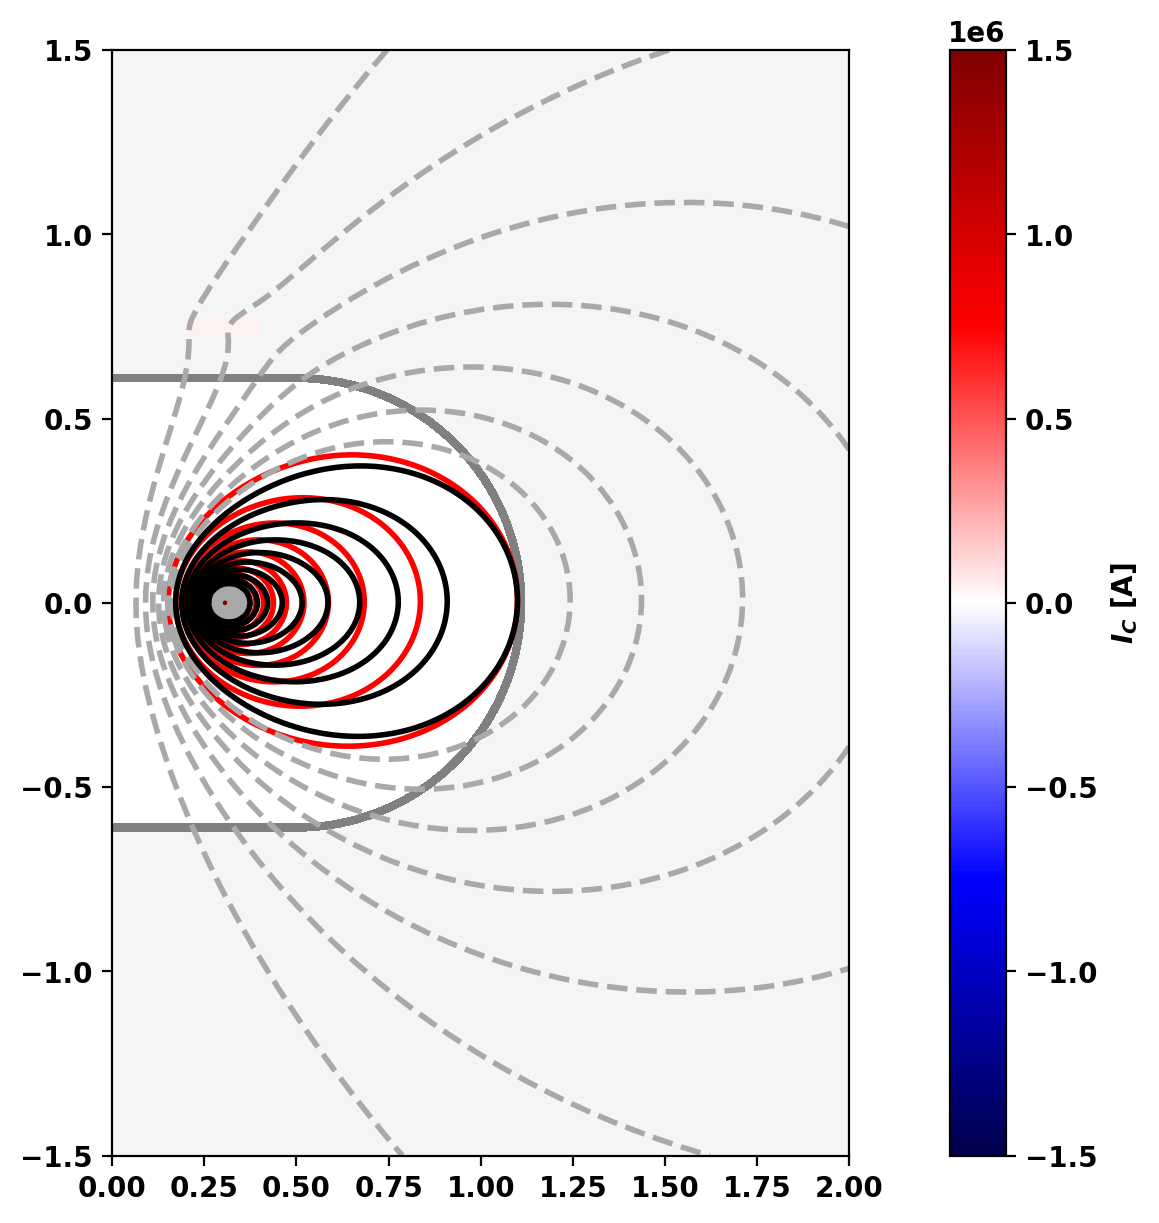

In [11]:
mygs.print_info(beta_Ip=coil_currents['DIPOLE']*dipole_nturns)
#
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_init,plasma_nlevels=10,plasma_color='r',vacuum_nlevels=0,xpoint_color=None,opoint_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color='tab:green',opoint_color=None)

## Compute stability

   1  2.7120E+01


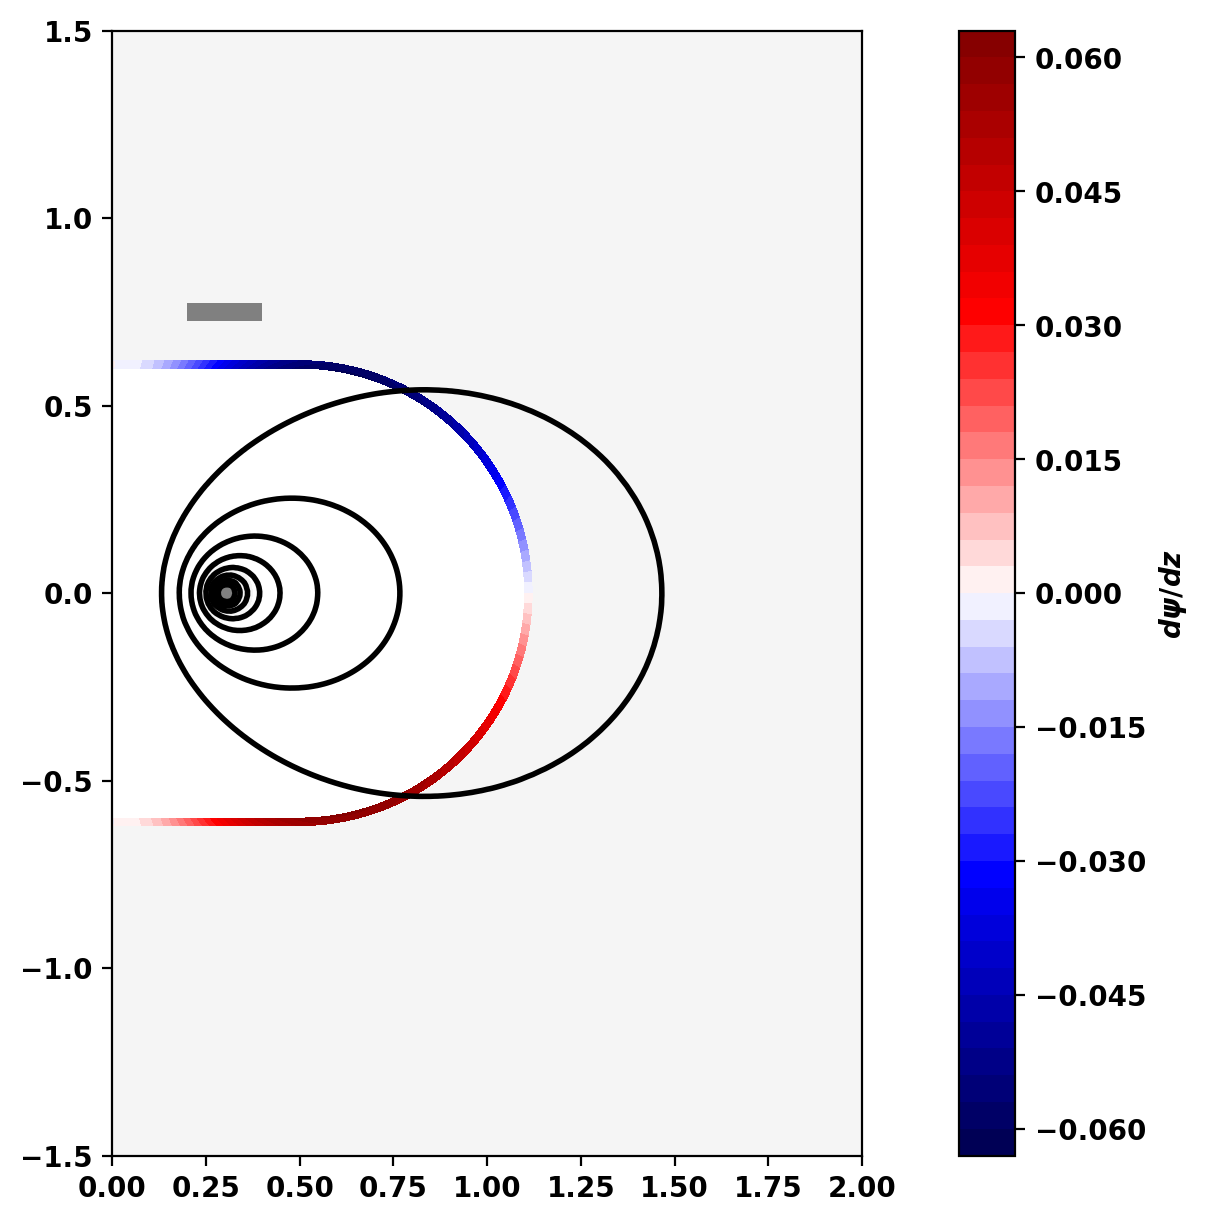

In [12]:
mygs.set_coil_currents({'DIPOLE': 1.5E4})
psi_dipole = mygs.vac_solve()
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_dipole,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None,opoint_color=None)
# Evaluate dBr/dz
mygs.set_psi(psi_dipole)
field_eval = mygs.get_field_eval('dPSI')
dpsi_dipole = np.zeros((mygs.r.shape[0],))
for i in range(mygs.r.shape[0]):
    if mygs.r[i,0] < 1.E-6:
        continue
    Btmp = field_eval.eval(mygs.r[i,:2])
    dpsi_dipole[i] = Btmp[1]
#
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[mygs.reg==mygs._cond_dict['VV']['reg_id'],:],dpsi_dipole,levels=40,cmap='seismic')
_ = fig.colorbar(clf,ax=ax,label=r'$d\psi/dz$')

In [13]:
urf = 0.7
vac_force_dz = unit_coil_force_dz*coil_currents['LEV']
wall_force_dz = 0.0
Br_wall = np.zeros((mygs.r.shape[0],))
#
mygs.settings.pm=False
mygs.update_settings()
mygs.set_coil_currents({})
for i in range(20):
    # Update gamma
    gamma = (vac_force_dz*coil_currents['DIPOLE'] + wall_force_dz*coil_currents['DIPOLE'])/dipole_mass
    print(i,gamma)
    gamma = max(0.0,gamma)
    if i == 0:
        gamma_curr = gamma
    else:
        gamma_curr = gamma*(1.0-urf) + gamma_curr*urf
    if gamma_curr < 0.0:
        raise ValueError('Negative growth rate in iteration')
    # Update wall response
    dt_curr = 1.0/gamma_curr
    mygs.set_psi_dt(dpsi_dipole*gamma_curr,dt_curr)
    mygs.set_psi(np.zeros_like(dpsi_dipole)) # Necessary temporarily to initialize zero flux for vacuum solves
    psi_last = mygs.vac_solve()
    mygs.set_psi(psi_last)
    field_eval = mygs.get_field_eval('B')
    for i in range(mygs.r.shape[0]):
        if pt_mask[i] == 0:
            continue
        Btmp = field_eval.eval(mygs.r[i,:2])
        Br_wall[i] = Btmp[0]
    wall_force_dz = -2.0*np.pi*mygs.area_integral(mygs.r[:,0]*Br_wall,reg_mask=dipole_reg)*dipole_nturns/dipole_area
print('Vertical growth rate = {0:.5E} [1/s]'.format(gamma))
#
mygs.set_psi_dt(np.zeros_like(dpsi_dipole),-1.0)
mygs.settings.pm=True
mygs.update_settings()

0 38.41257955226455
1 -224.9535310249208
2 -91.27053435009239
3 -25.351396467836476
4 7.092570890223767
5 15.149521899179168
6 10.257290667006231
7 13.189201496771307
8 11.410993936822173
9 12.48354428523896
10 11.834098312153126
11 12.226508045508623
12 11.989080586780522
13 12.132621242248515
14 12.045798538894324
15 12.098299065494718
16 12.066546996277559
17 12.085748420484908
18 12.07413598449606
19 12.081158553720558
Vertical growth rate = 1.20812E+01 [1/s]


Starting CG solver
     0  0.000000E+00  0.000000E+00  5.773972E-03
     1 -2.100566E-01  9.178735E+01  2.844179E-03  3.098661E-05
     2 -2.563114E-01  1.189948E+02  1.184057E-03  9.950492E-06
     3 -2.623576E-01  1.227670E+02  4.777334E-04  3.891383E-06
     4 -2.631265E-01  1.232376E+02  1.950897E-04  1.583038E-06
     5 -2.632798E-01  1.231471E+02  7.420087E-05  6.025386E-07
     6 -2.632979E-01  1.230166E+02  2.988918E-05  2.429687E-07
     7 -2.633008E-01  1.229646E+02  1.139988E-05  9.270860E-08
     8 -2.633012E-01  1.229559E+02  4.795356E-06  3.900061E-08
     9 -2.633013E-01  1.229556E+02  1.958408E-06  1.592777E-08
    10 -2.633013E-01  1.229564E+02  7.342864E-07  5.971924E-09
    20 -2.633013E-01  1.229573E+02  5.426164E-11  4.413048E-13


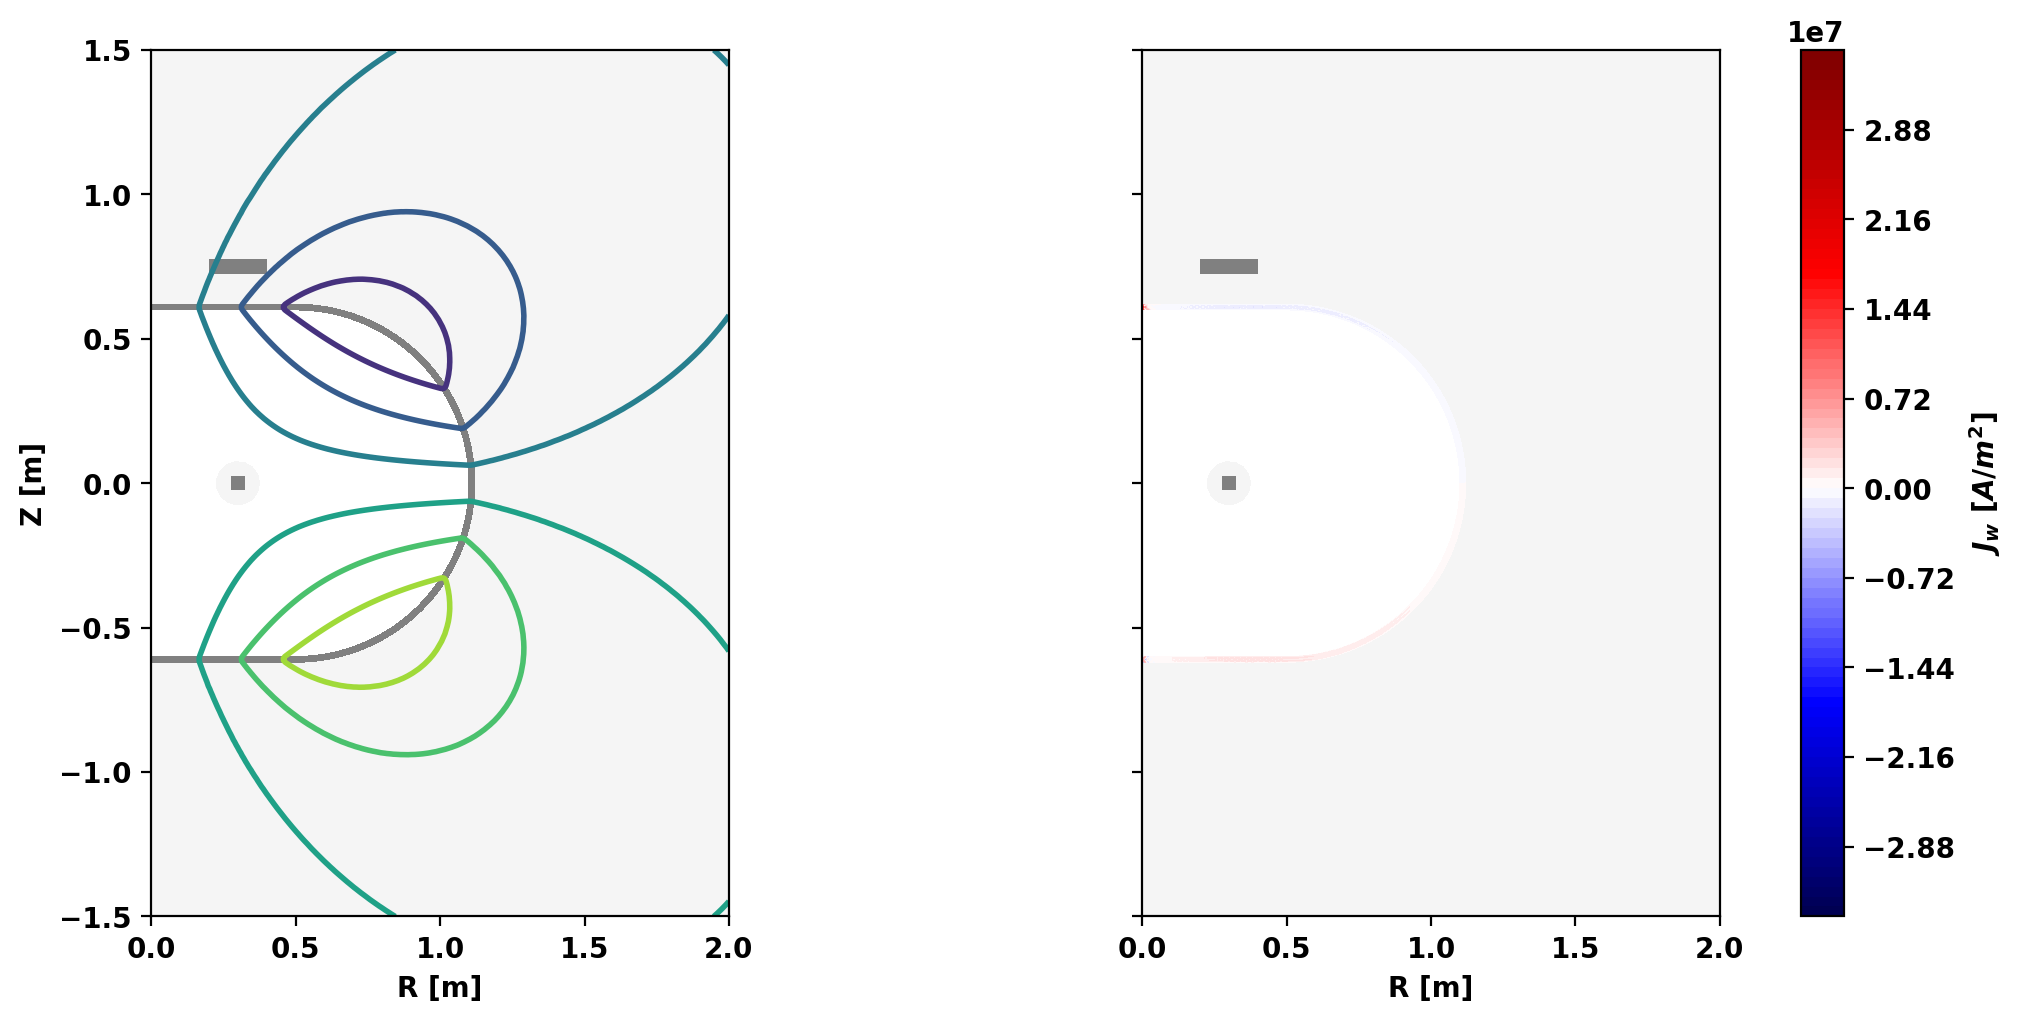

In [14]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,5),constrained_layout=True)

# Plot flux evolution in time
mygs.plot_machine(fig,ax[0],coil_colormap=None,limiter_color=None)
mygs.plot_psi(fig,ax[0],psi=psi_last,normalized=False,vacuum_levels=None,xpoint_color=None,opoint_color=None)

# Plot snapshot at end
mygs.plot_machine(fig,ax[1],coil_colormap=None,limiter_color=None)
mygs.plot_eddy(fig,ax[1],psi=psi_last,colormap='seismic',symmap=True,nlevels=100)

# Format plots
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[-1].set_xlabel('R [m]')